# **Decision Trees and Random Forests**

## **Intro**

### Alright lets move into our building our models. We are going to start with decision trees and then make the very logical transition into random forests. Why is this a logical transition you ask? Lets start with explaining what a decision tree is and how it works.

### The nice part about decision trees is that everyone already knows everything about decision trees, they just don't know they know. A decision tree is an algorithmic approach to arriving at a final decision using if/ else statements. Imagine you're trying to diagnose an illness based on a set of symptoms. You might start with a key symptom, say, "Is there a fever?" If yes, you then ask if the patient has a cough. Depending on that answer, you continue down a path of inquiry until you reach a probable diagnosis. This process of decision-making, based on asking a series of questions, is the essence of a decision tree in data science.

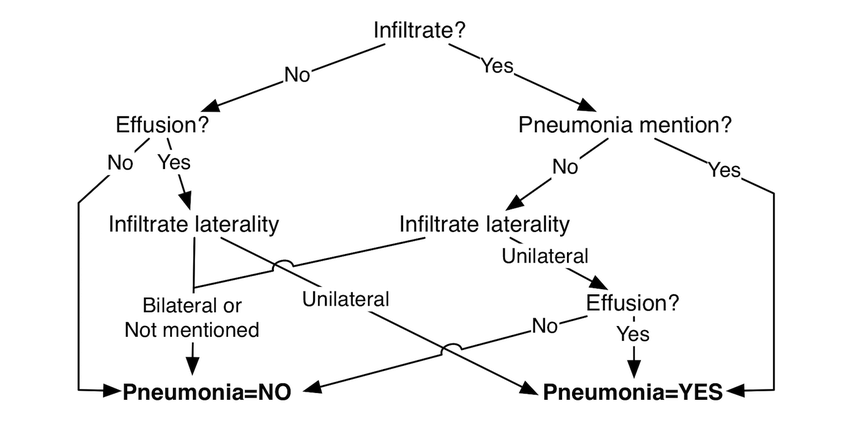

### At each "node" of the tree, the algorithm evaluates a feature and decides on a path to follow based on the outcome. This continues until we reach a "leaf" node, which provides the final decision (or prediction). While the tree metaphor might seem simplistic, decision trees are powerful tools and form the foundation for more complex algorithms (such as random forests and XGBoost). They are also highly transparent and can be visualized and interpreted easily. This makes decision trees particularly appealing for scenarios where understanding the reasoning behind predictions is highly important.

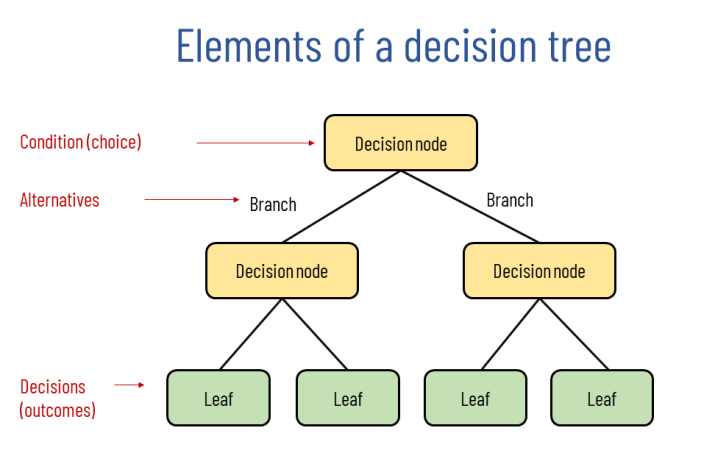


### while a single decision tree is insightful, it has its limitations. It can be overly sensitive to the data it's trained on, leading to overfitting. This means it might perform exceptionally well on training data but fail to generalize to new, unseen data. Random forests help mitigate this issue. Random forests are essentially committees of decision trees (or... a forest of many trees). Instead of relying on a single tree's decisions, a random forest aggregates the predictions of many trees. This not only improves accuracy but also helps to tackle the overfitting issue inherent in individual trees. Each tree in a random forest is trained on a random subset of the data and considers a random subset of features for making splits. This ensures diversity among the trees, which in turn leads to more robust and accurate predictions when they come together to vote on the final outcome.


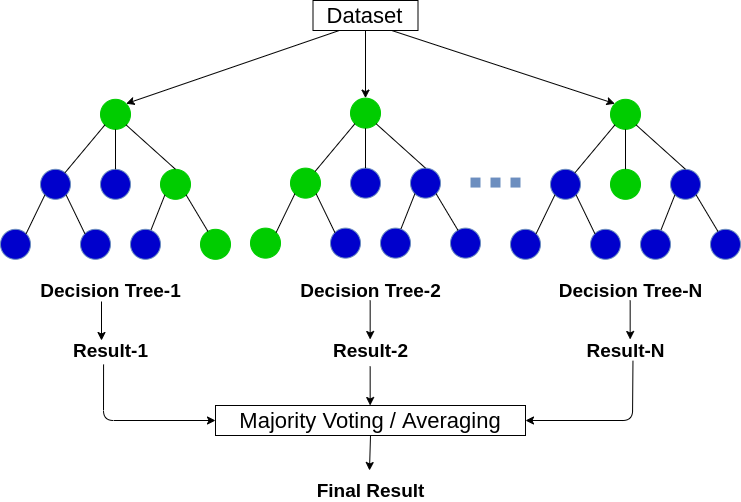

### It is important to keep in mind that the same principles of machine learning and data science apply here. We will train, test, deploy, avoid data leakage, and use similar metrics such as precision, recall, and area under the ROC curve (AUROC) to evaluate them. There will be some new metrics as well that are more specific to decision trees, but don't lose sight of the big picture (or... don't lose the forest through the trees....)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV
import numpy as np



### Import Data

In [3]:
# Import the dataset
df = pd.read_csv('hospital_readmissions.csv')

### Same preprocessing code from notebook 2 just applied here for consistency. You can skip this, but if you would like to try different preprocessing techniques you can do so here.  

In [4]:
# Do one hot encoding on medical specialty and the 3 diagnosis columns 
df_encoded = pd.get_dummies(df, columns=['medical_specialty'])
df_encoded = pd.get_dummies(df_encoded, columns=['diag_1'])
df_encoded = pd.get_dummies(df_encoded, columns=['diag_2'])
df_encoded = pd.get_dummies(df_encoded, columns=['diag_3'])

# Convert boolean columns (if any) to integers (1 and 0)
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)
        
# Make a dictionary of the age brackets where the key is the bracket and the value is the mean age
age_mapping = {
    '[40-50)': 45, 
    '[50-60)': 55, 
    '[60-70)': 65, 
    '[70-80)': 75, 
    '[80-90)': 85, 
    '[90-100)': 95
}

# Perform the actual mapping using the mapping method from pandas
df_encoded['age'] = df_encoded['age'].map(age_mapping)
# Make a dictionary of the categories where the key is the bracket and the value is the mean age
lab_mapping = {
    'no': 0, 
    'normal': 1, 
    'high': 2
}

# Perform the actual mapping using the mapping method from pandas
df_encoded['glucose_test'] = df_encoded['glucose_test'].map(lab_mapping)
df_encoded['A1Ctest'] = df_encoded['A1Ctest'].map(lab_mapping)

# Make a dictionary of the categories where the key is the bracket and the value is the mean age
binary_mapping = {
    'no': 0, 
    'yes': 1
    }

# Perform the actual mapping using the mapping method from pandas
df_encoded['change'] = df_encoded['change'].map(binary_mapping)
df_encoded['diabetes_med'] = df_encoded['diabetes_med'].map(binary_mapping)
df_encoded['readmitted'] = df_encoded['readmitted'].map(binary_mapping)


## **Build Decision Trees**

### Let's start with just making a decision tree using tools from `sklearn` so you can see what they are all about and observe the building block of what will become the forest
### We will start via the same method of creating our predictor (all the data minus `readmitted`) and our target (`readmitted`). We will then split the data into training and testing sets per-usual

In [5]:
# Set the target variable and drop it from the dataset
y = df_encoded['readmitted']
X = df_encoded.drop(['readmitted'], axis=1)

# Splitting the data. We're keeping 20% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Now we will train a decision tree classifier. The goal here is not to build the optimal decision tree, but rather just to illustrate practically how to make one. Lets breifly discuss the 'under the hood mechanics of how decision tree models actually make their decisions. It is important to understand this principle well as other machine learning models are built upon the fundamentals of decision trees.

### We know that decision trees start at the top of the tree, or root node. This node is determined by the feature in the data that has the lowest 'Gini Impurity' (information gain is another metric you can use, but we will use Gini here). Gini impurity is a number that is 0-0.5, and gives the liklihood that new, random data would be misclassified if it were given a random class label. For example, if we introduced a new patient into the dataset and tried to use a decision tree with .5 Gini impurity to predict readmission, we would essentially be flipping a coin. The goal of the deision tree through training and updating its weights is thus to *minimize* the Gini impurity. It does this by starting at the root and traversing down the tree, making decisions at each node based on the splits defined during the training process. Once it reaches a leaf node, it returns the class that represents the majority of the samples at that leaf as the final prediction. The process of deciding where to split a node involves examining every unique value of every feature as a potential threshold. The Gini impurity for each potential split is calculated, and the one that results in the most significant decrease in impurity is chosen. 

### In a nutshell, the model will iteratively try to make a split based on every feature for each node in the tree, using the Gini impurity metric the deciding factor. You can read about the math behind how gini impurity is calculated, but this is the high level approach.

### There are three main hyperparameters that you can tune for decision trees. You can do this manually, or via automated methods which we will discuss in the random forests section, but it is important to at least have an idea what these hyperparameters mean:

### 1.Max Depth: This can act as a pruning technique. By limiting the depth of the tree, we can ensure it doesn’t capture noise and overfit. However, if set too low, the tree might be too simplistic to capture the underlying patterns.

### 2. Min Samples Split: This parameter can help control the size of the tree. By setting it to a higher value, you ensure that a node must have at least that many samples before it considers splitting. This can be useful in scenarios where you don’t want tiny splits capturing minute data patterns.

### 3. Min Samples Leaf: Similarly, by ensuring a minimum number of samples in a leaf, we can avoid having leaves that make decisions based on very few samples, which can be unreliable.

### OK! Lets now do it. As always, notice that the code to do these things are easy. It really is the conceptual understanding that is important.

In [6]:

# Create a decision tree classifier. Setting max_depth limits the depth of the tree which can make visualization easier.
dt = DecisionTreeClassifier(max_depth=3, random_state=42)

# Training the classifier on training data
dt.fit(X_train, y_train)


# make predictions on test set
y_pred = dt.predict(X_test)

# get the predicted probablity estimates for each class rather than the labels
#.predict_proba is a method available in many scikit-learn classifiers. When called, it returns the probability estimates for each class, rather than the predicted class labels themselves.
# [:, 1]: indexing the 2D array returned by predict_proba. ':' denotes all rows, and 1 denotes the second column, so, extracts the probabilities corresponding class 1 in binary classification
y_pred_prob = dt.predict_proba(X_test)[:, 1]

# find area under receiving operating curve
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Get the classification report
report = classification_report(y_test, y_pred)

# Print results
print('ROC-AUC \n', roc_auc)
print('Classification report: \n', report)

ROC-AUC 
 0.6273733196081116
Classification report: 
               precision    recall  f1-score   support

           0       0.61      0.71      0.66      2658
           1       0.60      0.49      0.54      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.60      5000
weighted avg       0.61      0.61      0.60      5000



### Even though we have talked about the interpretation of precision and recall values ad nauseum, it is still very important to look at these at a glance and know whats going on, so heres a etailed breakdown.

### **Classification Report**
- ### Precision for Class 0 : Out of all the instances predicted as not readmitted 62% of them were accurate.
- ### Precision for Class 1: For those predicted as readmitted, 61% were correct. This suggests that a notable number of predictions for this class might be false positives.
- ### Recall for Class 0: Among the true not readmitted instances, the model accurately predicted 72%. This implies that the model missed 28% of the true negatives, categorizing them as false negatives.
- ### Recall for Class 1: For the actual readmitted instances, the model managed to identify 49% correctly. This indicates potential room for improvement in detecting readmissions, given the relatively lower recall rate for this class.
- ### Accuracy: The overarching prediction accuracy of the model is 61%. This denotes that for every 100 predictions, the model got 61 of them right.

### **ROC-AUC**
- ### The ROC-AUC score was 0.6274. While this is higher than 0.5, it signifies that the model has a moderate capability to differentiate between readmission and not

### So overall, not a homerun, but definitely not a total bust. The decision tree seemed to do a good job at detecting when someone was not going to get readmitted, but was only about 50% at predicting readmissions, which would probably be a more useful metric anyway. We could definitely spend more time with this model tryinng to improve its performance (and you should on your own!), but we will move on to the random forest to try as it makes use of multiple trees and is less prone to overfitting,

### One of the nice things about decision trees is that they are very interpretable, meaning we can directly visualize the branches it made. Lets do this by plotting it in matplotlib.

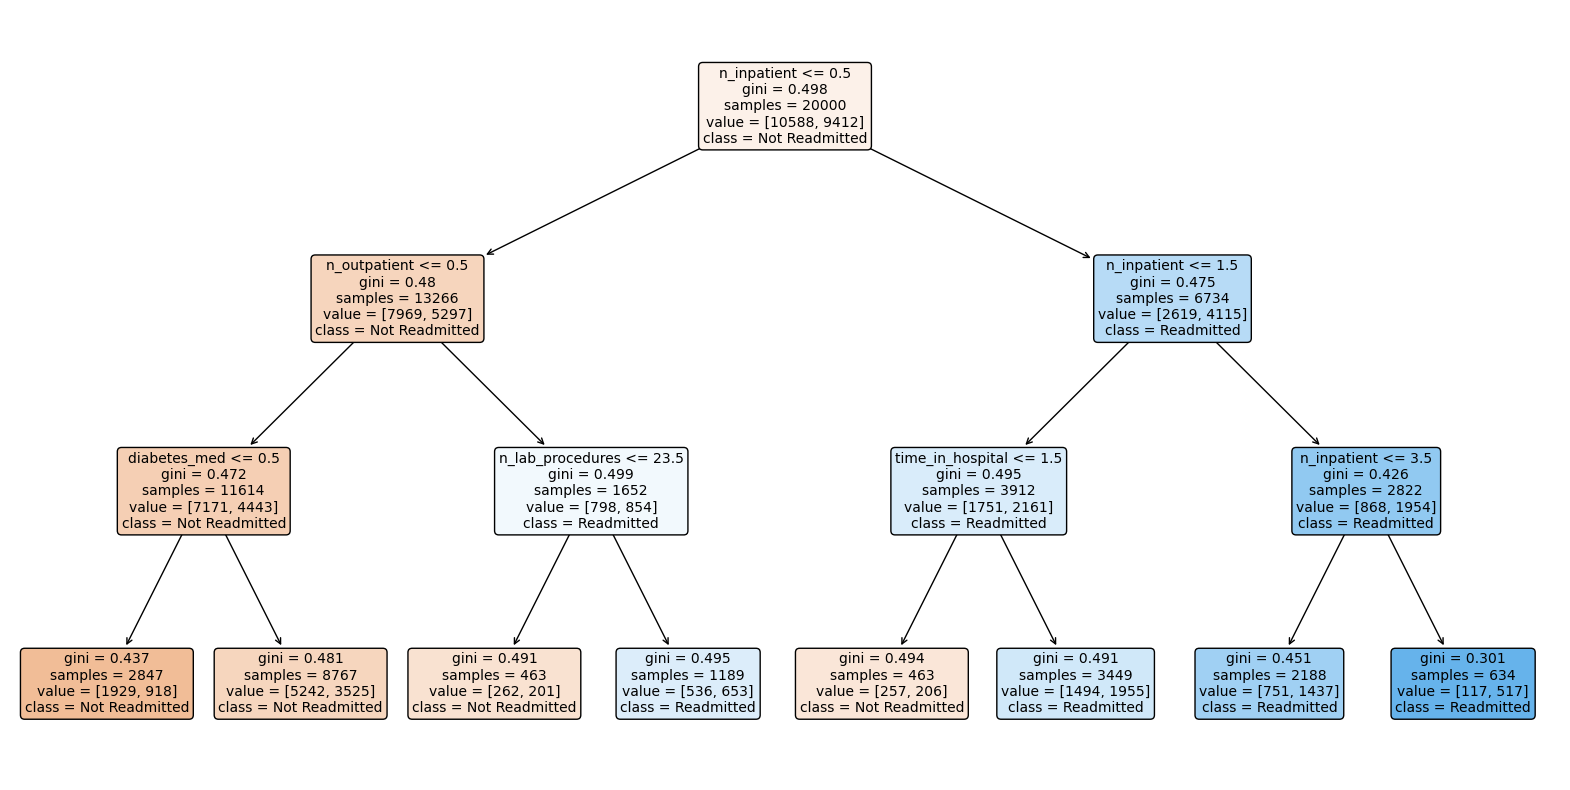

In [7]:
# Initialize a large figure for plotting
plt.figure(figsize=(20,10))

# Plot the trained decision tree 'dt'. 
# feature_names: Use the columns of X as feature names
# class_names: Provide labels for the two classes predicted by the tree
# filled: Color the nodes by class, intensity indicates purity
# rounded: Make the node boxes have rounded corners
plot_tree(dt, feature_names=X.columns, class_names=['Not Readmitted', 'Readmitted'], filled=True, rounded=True)

# Display the decision tree plot
plt.show()


### This can admittedly be a lot when you look at it for the first time so lets break it down, starting from the root (top) node.

### We see the first feature was n_inpatient (number of inpatient visits) with a Gini impurity of .498. 20,000 samples are at this level of the tree (which makes sense because we did an 80/20 training test split with 25,000 total rows), and 10,588 who were not readmitted, 9412 who were readmitted. At this node, it is saying 'If you have 0 (<.5) inpatient visits, you will move to the left into the 'not readmitted' branch. It also says if you have 1 or more inpatient visits (>.5) you will move to the right of the tree to the 'reeadmitted side.

### The logic is the same for the nodes on the other other branches. After the initial population has been funneled from the root, on the left side this node is saying of the people that had 0 inpatient visits, if they had 0 (<.5) oupatient visits they will go to the left (readmitted), and if they had 1 or more outpatient visits they will to the righjt (readmitted, with a very high Gini impurity that is basially a coin toss).

### On the right side of the second branch it is making the number of inpatient vists a little more strict, saying if you had 2 or more inpatient visits you were likely readmitted with a Gini impurity of .475, the next branch on the right is 4 or more inpatient visits, and if you met all of those criteria the tree would then classify you as readmitted with a Gini impurity of .301 (leaf node). 

### So we can see from this, by looking at the right side of the plot that the model clearly thought that a higher number of inpatient visits in the past year are very important predictors of being readmitted, which also makes sense. On the left side the model thought that having less outpatient visits and not taking any diabetes medications were important predictors of not being readmited, which also kind of make sense.

### So while these kinds of trees can be a lot at first glance, when you really start to break them down they are actually quite intuitive and easy to read once you get your head around how to.

### Now that we are experts in decision trees (even though you already were and didn't know it) lets move into Random Forests and see if we can improve our classifier!

## **Random Forests**

### Now let's move onto Random Forests. As decision trees can be prone to overfitting and might not generalize well outside of the testing data, we can use Random Forests to build upon the foundation of decision trees and improve our model. As the name implies, Random Forests essentially construct an "ensemble" of multiple trees. The idea is that a group (or ensemble) of models can collectively make a more accurate prediction than any individual model on its own.

### At the core of how Random Forest's work is a concept called bagging, or bootstrap aggregating. we can break bagging down into three steps.

### 1.Bootstrap Sampling: For each tree in the forest, we take a random subset (or sample) of the data with replacement. This means some data points may be repeated in the sample, while others might be left out entirely. This random subsampling creates unique datasets for training each tree in the forest. Bootstrap sampling is easier visualized with an image. Note in the figure below how the data can be repeated in different samples. This works because, on average, each dataset is a unique subset of the original

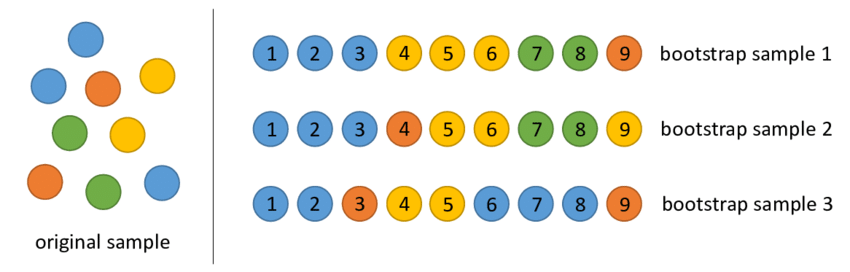

### 2. Model Building: A decision tree is then trained on each of these bootstrap samples. Because each tree sees a slightly different set of data, they will each learn different things and make different decisions. We can specify the number of decision trees we use in a Random Forest, and this is a very important hyperparameter.

### 3. Aggregation: When making a prediction, each tree in the forest gets a "vote". For classification tasks, the class with the most votes becomes the forest's prediction. For regression tasks, the average prediction of all trees is used. 

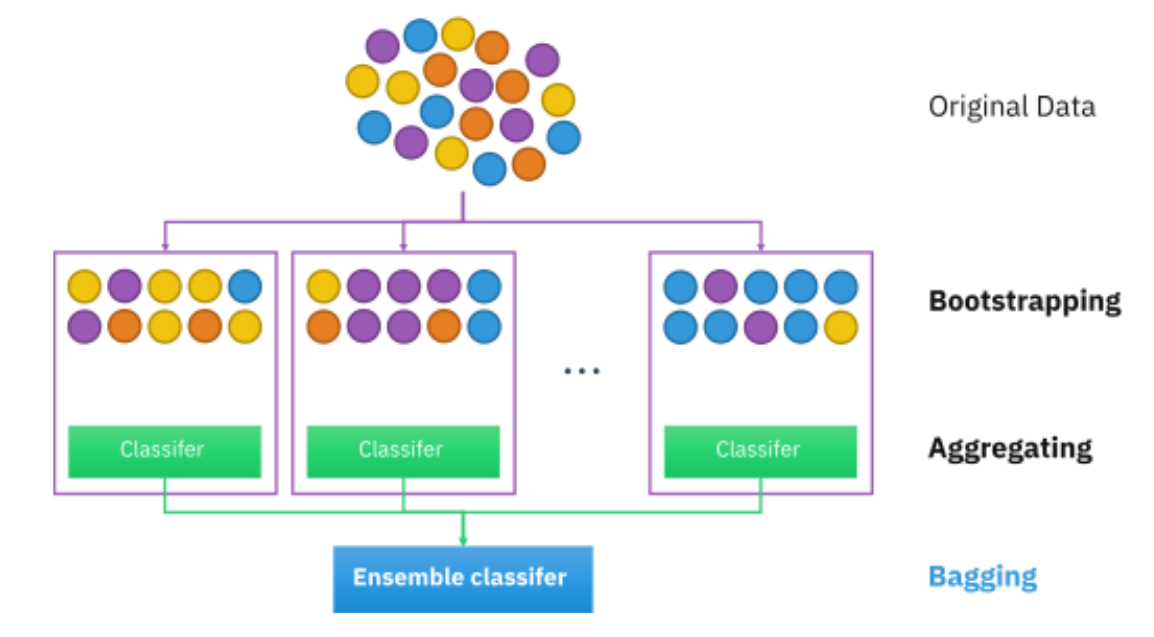

### Bootstrapping is such an important part of Random Forests as it reduces overfitting and improves model stability by training the individual trees on different subsets of data, and as such can often result in improved accuracy. There is definitely a lot of math under the hood here that permits this to work, and we won't go into it here, but just know that the concept of bagging is ultimately what allows Random Forests to harness the power of many individual decision trees.

### Now, lets actually build a random forest. You will see that the actual code for this is quite similar to the decision trees, with the main difference being we now specify the `RandomForestClassifer` class instead of `DecisionTreeClassifier`. We also set initial hyperparameters to 200 trees with a max depth of 50.

In [8]:
# Create a random forest classifier. We can adjust these parameters later if needed.
# - `n_estimators` specifies the number of trees in the forest.
# - `max_depth` limits the maximum depth of the trees.
# - `random_state` is set for reproducibility across multiple function calls.
# - `bootstrap=True` indicates that bootstrap samples are used when building trees.

rf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=42, bootstrap=True)

# Training the classifier
rf.fit(X_train, y_train)

# Making predictions on test set
y_pred = rf.predict(X_test)

# get the predicted probablity estimates for each class rather than the labels
#.predict_proba is a method available in many scikit-learn classifiers. When called, it returns the probability estimates for each class, rather than the predicted class labels themselves.
# [:, 1]: indexing the 2D array returned by predict_proba. ':' denotes all rows, and 1 denotes the second column, so, extracts the probabilities corresponding class 1 in binary classification
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Get AUROC
roc_auc = roc_auc_score(y_test, y_pred_prob)

print('ROC-AUC \n', roc_auc)
print("Model Accuracy: \n ", accuracy_score(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

ROC-AUC 
 0.6446939423322209
Model Accuracy: 
  0.6116
Classification report: 
               precision    recall  f1-score   support

           0       0.62      0.70      0.66      2658
           1       0.60      0.51      0.55      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.60      5000
weighted avg       0.61      0.61      0.61      5000



### Great! Lets break down these results like we normally do.

### **Classification Report**
### - Precision for Class 0: Out of all the instances predicted as not readmitted, 62% of them were accurate.
### - Precision for Class 1: For those predicted as readmitted, 60% were correct. 
### - Recall for Class 0: Among the true not readmitted instances, the model accurately predicted 70%. This means that the model failed to correctly identify 30% of the true negatives, classifying them as false negatives.
### - Recall for Class 1: For the actual readmitted instances, the model managed to identify 51% correctly, slightly better than our decision tree, but still not great.
### - Accuracy: The model's overall prediction accuracy stands at 61.16%. This suggests that out of every 100 predictions made by the model, roughly 61 were correct.
### **AUROC**
### - We got an ROC-AUC score of 0.6447. This is better than our decision tree by about 2%, so that is good! It means this is a slightly better classifier.

### Ok so putting it all together, we did improve slightly using a random forest than using just a decision tree, which is great! However, we still could probably improve this model a little bit. How might we go about this?

### We could, as always, go back to the data cleaning steps and try some different pre-processing. However, we could also try hyperparameter tuning. Both Decision Trees and Random Forests require hyperparameters in order to try and fit. These hyperparameters are essentially 'little knobs' that fine tune the model during training to improve its performance, and what you set them to initially has a huge impact on the model's performance. As you do more machine learning you will develop an intuition about where to start, but there are automated ways to optimize your hyperparamerts buuilt into Python, and we will show you how to do this now.

### The two main types of hyperparameter optimization are random search and grid search. Random search will try and find a rough estimate of the optimal hyperparameters within a certain range, and grid search will be more specific and try to identify the truly optimal hyperparameters for your model. A common approach is to start with random search and move to grid search. Here we will just do a random search hyperparameter optimization on the following hyperparameters:

- ### n_estimators- number of trees in the forest
- ### max_depth- maximum depth of the tree
- ### min_samples_split- number of samples considered before splitting at a node
- ### min_samples_leaf- number of samples a leaf must consider 

### Lets do this optimization on our random forest model!

In [9]:
# Define hyperparamters we want to finetune as well as the range of values we want to search over 
param_dist = {
    'n_estimators': np.arange(10, 500, 10),
    'max_depth': np.arange(1, 40),
    'min_samples_split': np.arange(2, 50),
    'min_samples_leaf': np.arange(1, 50)
}

# reinitialize the model to reset the weights 
rf = RandomForestClassifier()

# Do randomized search to get a rough estimate of optial parameters. 'rf_random_search' is the resutlant
# random forest model with the estimated ideal hyperparamters
# n_iter will determine how many iterations it searches for- it can take a long time at high values so make sure you have coffee!
rf_random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=200,scoring='roc_auc', cv=5, verbose=0, random_state=42, n_jobs=-1)

# Train model doing hyperparameter optimization so we can later use the best model
rf_random_search.fit(X_train, y_train)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       3...
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490])},
                   random_state=42, scoring='roc_auc')

### Now lets use the trained model (after hyperparameter tuning) and see if we improved the performance 

In [11]:
# After the hyperparameter optimization process, retrieve the best Random Forest model.
best_rf = rf_random_search.best_estimator_
best_parameters = rf_random_search.best_params_
print(best_parameters)
# Use the best model to predict on the test data.
y_pred = best_rf.predict(X_test)

# Generate a classification report that gives precision, recall, f1-score for each class.
report = classification_report(y_test, y_pred)

# Calculate the predictions into probabilities for the positive class for ROC-AUC score.
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

# Calculate the ROC-AUC score for the predictions.
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Display the classification report and ROC-AUC score.
print('Classfication Report: \n:', report)
print('ROC-AUC \n', roc_auc)

{'n_estimators': 450, 'min_samples_split': 35, 'min_samples_leaf': 2, 'max_depth': 12}
Classfication Report: 
:               precision    recall  f1-score   support

           0       0.62      0.74      0.67      2658
           1       0.62      0.48      0.54      2342

    accuracy                           0.62      5000
   macro avg       0.62      0.61      0.61      5000
weighted avg       0.62      0.62      0.61      5000

ROC-AUC 
 0.662335446734766


### Lets break down these results!

### **Classification Report**
### - Precision for Class 0: Of all instances predicted as not readmitted, 62% of them were accurate.
### - Precision for Class 1: For the predictions labeled as readmitted, 61% turned out to be correct.
### - Recall for Class 0: When considering actual instances of not being readmitted, the model predicted correctly 73% of the time. 
### - Recall for Class 1: Among actual readmitted instances, the model managed to correctly predict 49% of them. 
### - Accuracy: Overall, the model achieved an accuracy of 62%, meaning out of every 100 predictions, 62 were correct.

### **AUROC**
### The model attained an ROC-AUC score of 0.6602, 2 percent better than without hyperparameter optimization! 

### Do to the increased recall and AUROC score, it is safe to say that this model, after hyperparamter tuning, is slightly better at predicting hospital readmissions, which is great! When you compare the AUROC of this to a single decision tree (.660 to .627), theres definitely an increase which was the whole point of going down this road in the first place.

### There are certainly more ways to improve this model ranging from feature selection to differnet preprocessing techniques, but we will not be going on that journey with you. We do hope, however, that this notebook has served as a good intro to decision trees and random forests, as these are truly fundamental tools in the machine learning toolkit.

### We will, however, make one last attempt to improve our performance in the next notebook where we will introduce you to XGBoost. See you over there!